#  Statistical Relational Learning with `pslpython`

As we've seen there are several ways to work with graph-based data, including: SPARQL queries, graph algorithms traversals, ML embedding, etc.
Each of these methods makes trade-offs in terms of:

  * computational costs as the graph size scales
  * robustness when there is uncertainty or conflicting information in the graph
  * formalism (i.e., *analytic solutions*) vs. empirical approaches (i.e., data-driven, machine learning)

One way to visualize some of these trade-offs is in the following diagram:

<img src="https://github.com/DerwenAI/kglab/blob/main/docs/tradeoffs.png?raw=true" width="400"/>

Note in the top/right corner of the diagram that a relatively formal category of graph-based approaches is called [*statistical relational learning*](https://www.cs.umd.edu/srl-book/).
The gist is that so much of the *network analysis* that we want to perform can be describe mathematically as [*markov networks*](https://en.wikipedia.org/wiki/Markov_random_field), in terms of probabilistic models.
Sometimes these can be quite computationally expensive; for example, hedge funds on Wall Street tend to burn lots of cloud computing on markov models.
They are *robust* in terms of being able to work well even with lots of missing or conflicting data, and the *formalism* implies that we can infer mathematical guarantees from the analyis.
That's quite the opposite of deep learning models, which are great at predicting sequences of things, but terrible at providing guarantees.


Clearly, there's been much emphasis in industry recently that equates "artificial intelligence" with "deep learning", although we are also recognizing [*diminishing returns*](https://derwen.ai/s/zf43#33) for methods that rely purely on ever-larger data rates and ever-larger ML models.
One path forward will be to combine machine learning with use of *structured knowledge* (i.e., KGs) such that we can avoid "boiling the oceans" with purely data-driven approaches when in so many use cases we can leverage domain expertise.

In this secton we'll consider one form of statistical relational learning called [*probabilistic soft logic*](https://psl.linqs.org/) (PSL) which is essentially a kind of "fuzzy logic" for graphs that has interesting computational qualities.
Whereas many kinds of formal graph analysis (e.g., "traveling salesman problem") are provably hard and quite expensive in practice, PSL can be solved with a *convex optimization* (e.g., like so many machine learning algorithms).

Consider this: we can describe "rules" about nodes and relations in a KG, then assign probabilities to specific instances of those rules that are found within our graph.
If the probabilities are all *zero* then the system is consistent.
As some of the assigned probabilities are increased, then some of the rules become inconsistent.
How high (i.e., optimal) of a set of probabilities can we assign while still keeping the system consistent?
Alternatively, if we apply a set of rules, then how "far away" (probabilistically speaking) is a graph from being logically consistent?

This comes in quite handy when we want to combine *semantic technologies* and *machine learning*, or rather when we have explicit rules plus lots of empirical data.
Data quality is a persistent problem, so we can leverage PSL to identify which parts of the graph seem the least "logically consistent", and therefore need some review and curation.

## RDF representation of the "simple acquaintances" example

One of the examples given for PSL is called [*simple acquaintances*](https://github.com/linqs/psl-examples/tree/master/simple-acquaintances), which uses a graph of some friends, where they live, what interests they share, and then infers who probably knows whom.
Some people explicitly do or do not know each other, while other "knows" relations can be inferred based on whether two people have lived in the same place or share common interest.

The objective is to build a PSL model for [*link prediction*](https://en.wikipedia.org/wiki/Link_prediction), to evaluate the annotations in the friend graph.
In this case, we'll assume that the "knows" relations have been added from a questionable source (e.g., some third-party dataset) so we'll measure a subset of these relations and determine their likelihood.
NB: this is really useful for cleaning up annotations in a large graph!

First, let's load a KG which is an RDF representation of this example, based on a simple extension of the [`foaf`](http://www.foaf-project.org/) vocabulary:

In [1]:
import kglab

namespaces = {
    "acq": "http://example.org/stuff/",
    "foaf": "http://xmlns.com/foaf/0.1/",
    "rdfs": "http://www.w3.org/2000/01/rdf-schema#",
    }

kg = kglab.KnowledgeGraph(
    name = "LINQS simple acquaintance example for PSL",
    base_uri = "http://example.org/stuff/",
    language = "en",
    namespaces = namespaces,
    )

kg.load_ttl("dat/acq.ttl")

Take a look at the `dat/acq.ttl` file to see the people and their relations.
Here's a quick visualization of the graph:

In [2]:
VIS_STYLE = {
    "foaf": {
        "color": "orange",
        "size": 5,
    },
    "acq":{
        "color": "blue",
        "size": 30,
    },
}

g = kg.vis_pyvis(notebook=True, style=VIS_STYLE)
g.barnes_hut()
g.show("tmp.html")

Also, let's serialize this in TTL/Turtle format, then view the resulting `foo.ttl` file to see the relations organized in a way that's probably more readable:

In [3]:
kg.save_ttl("foo.ttl")

## Loading a PSL model

Next, we'll use the (`pslpython`](https://pypi.org/project/pslpython/) library implemented in Python (atop Java core software) to define three *predicates* (i.e., relations – similar as in RDF) which are: `Neighbors`, `Likes`, `Knows`

In [4]:
from pslpython.model import Model
from pslpython.partition import Partition
from pslpython.predicate import Predicate
from pslpython.rule import Rule

model = Model("simple acquaintances")

# add predicates
predicate = Predicate("Neighbors", closed=True, size=2)
model.add_predicate(predicate)

predicate = Predicate("Likes", closed=True, size=2)
model.add_predicate(predicate)

predicate = Predicate("Knows", closed=False, size=2)
model.add_predicate(predicate)

Next, we'll add a set of probabilistic [*rules*](https://psl.linqs.org/wiki/2.2.1/Rule-Specification.html), all with different weights applied:

  1. "Two people who live in the same place are **more** likely to know each other"
  2. "Two people who don't live in the same place are **less** likely to know each other"
  3. "Two people who share a common interest are **more** likely to know each other"
  4. "Two people who both know a third person are **more** likely to know each other"
  5. "Otherwise, any pair of people are **less** likely to know each other"

In [5]:
model.add_rule(Rule("20: Neighbors(P1, L) & Neighbors(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))

model.add_rule(Rule("5: Neighbors(P1, L1) & Neighbors(P2, L2) & (P1 != P2) & (L1 != L2) -> !Knows(P1, P2) ^2"))

model.add_rule(Rule("10: Likes(P1, L) & Likes(P2, L) & (P1 != P2) -> Knows(P1, P2) ^2"))

model.add_rule(Rule("5: Knows(P1, P2) & Knows(P2, P3) & (P1 != P3) -> Knows(P1, P3) ^2"))

model.add_rule(Rule("5: !Knows(P1, P2) ^2"))

Finally we'll add a *commutative* rule such that "If Person 1 knows Person 2, then Person 2 also knows Person 1."

In [6]:
model.add_rule(Rule("Knows(P1, P2) = Knows(P2, P1) ."))

To initialize the model, we'll clear any pre-existing data from each of the predicates:

In [7]:
for predicate in model.get_predicates().values():
    predicate.clear_data()

And we'll define a simple helper function, to format a unique URL within our `acq` vocabulary (a simple extension of `foaf`) based on the purely numeric identifiers used within PSL:

In [8]:
def get_person_id (url):
    return url.replace("http://example.org/stuff/person_", "")

Let's query our KG to populate data into the `Neighbors` predicate in the PSL model, based on `foaf:based_near` that represents living near the same locations:

In [9]:
predicate = model.get_predicate("Neighbors")

query = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
      ?p1 foaf:based_near ?l .
      ?p2 foaf:based_near ?l .
  }
  """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])

    if p1 != p2:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])

Note: these data points are *observations*, i.e., empirical support for the probabilistic model.
    
Then let's query our KG to populate data into the `Likes` predicate in the PSL model, based on shared interests in `foaf:topic_interest` topics:

In [10]:
predicate = model.get_predicate("Likes")
    
query = """
SELECT DISTINCT ?p1 ?p2
  WHERE {
      ?p1 foaf:topic_interest ?t .
      ?p2 foaf:topic_interest ?t .
  }
  """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])

    if p1 != p2:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2])

Just for kicks, let's take a look at the internal representation of a PSL predicate, which is a `pandas` DataFrame:

In [11]:
predicate = model.get_predicate("Likes")
predicate.__dict__

{'_types': [<ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>,
  <ArgType.UNIQUE_STRING_ID: 'UniqueStringID'>],
 '_data': {<Partition.OBSERVATIONS: 'observations'>:       0   1    2
  0    20  13  1.0
  1    20   1  1.0
  2    20   3  1.0
  3    20  10  1.0
  4    20  24  1.0
  ..   ..  ..  ...
  567   5  21  1.0
  568  14  24  1.0
  569   6  14  1.0
  570   6  16  1.0
  571   6  18  1.0
  
  [572 rows x 3 columns],
  <Partition.TARGETS: 'targets'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: [],
  <Partition.TRUTH: 'truth'>: Empty DataFrame
  Columns: [0, 1, 2]
  Index: []},
 '_name': 'LIKES',
 '_closed': True}

Now we'll load data from the `dat/psl/knows_targets.txt` CSV file, which is a list of `foaf:knows` relations in our graph that we want to analyze.
Each of these has an assumed value of `1.0` (true) or `0.0` (false).
Our PSL analysis will assign probabilities for each so that we can compare which annotations appear to be suspect and require further review:

In [12]:
import csv
import pandas as pd
import rdflib as rdf

targets = []
rows_list = []
predicate = model.get_predicate("Knows")

with open("dat/psl/knows_targets.txt", "r") as f:
    reader = csv.reader(f, delimiter="\t")
    
    for i, row in enumerate(reader):
        p1, p2 = row
        targets.append((p1, p2))
    
        p1_url = rdf.URIRef("http://example.org/stuff/person_" + p1)
        p2_url = rdf.URIRef("http://example.org/stuff/person_" + p2)
        
        if (p1_url, kg.get_ns("foaf").knows, p2_url) in kg._g:
            truth = 1.0
            predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)
            predicate.add_data_row(Partition.TARGETS, [p1, p2])
            rows_list.append({ 0: p1, 1: p2, "truth": truth})
        elif (p1_url, kg.get_ns("acq").wantsIntro, p2_url) in kg._g:
            truth = 0.0
            predicate.add_data_row(Partition.TRUTH, [p1, p2], truth_value=truth)
            predicate.add_data_row(Partition.TARGETS, [p1, p2])
            rows_list.append({ 0: p1, 1: p2, "truth": truth})
        else:
            print("UNKNOWN", p1, p2)

df_dat = pd.DataFrame(rows_list)   

These data points are considered to be *ground atoms*, each with a *truth* value set initially.
These are also our *targets* for which nodes in the graph to analyze based on the rules.

Next, we'll add `foaf:knows` observations which are in the graph, although not among our set of targets.
This provides more evidence for the probabilistic inference.
Note that since RDF does not allow for representing probabilities on relations, we're using the `acq:wantsIntro` to represent a `foaf:knows` with a `0.0` probability:

In [13]:
predicate = model.get_predicate("Knows")

query = """
SELECT ?p1 ?p2
  WHERE {
      ?p1 foaf:knows ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])
    
    if (p1, p2) not in targets:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=1.0)
    
query = """
SELECT ?p1 ?p2
  WHERE {
      ?p1 acq:wantsIntro ?p2 .
  }
  ORDER BY ?p1 ?p2
  """

for row in kg.query(query):
    p1 = get_person_id(row[0])
    p2 = get_person_id(row[1])
    
    if (p1, p2) not in targets:
        predicate.add_data_row(Partition.OBSERVATIONS, [p1, p2], truth_value=0.0)

Now we're ready to optimize the PSL model – this may take a few minutes to run:

In [14]:
PSL_OPTIONS = {
    "log4j.threshold": "INFO"
}

results = model.infer(additional_cli_optons=[], psl_config=PSL_OPTIONS)

6357 [pslpython.model PSL] INFO --- 0    [main] INFO  org.linqs.psl.cli.Launcher  - Running PSL CLI Version 2.2.2-5f9a472
6680 [pslpython.model PSL] INFO --- 325  [main] INFO  org.linqs.psl.cli.Launcher  - Loading data
6956 [pslpython.model PSL] INFO --- 601  [main] INFO  org.linqs.psl.cli.Launcher  - Data loading complete
6958 [pslpython.model PSL] INFO --- 601  [main] INFO  org.linqs.psl.cli.Launcher  - Loading model from /var/folders/zz/2ffrqd5j7n52x67qd94h_r_h0000gp/T/psl-python/simple acquaintances/simple acquaintances.psl
7148 [pslpython.model PSL] INFO --- 792  [main] INFO  org.linqs.psl.cli.Launcher  - Model loading complete
7149 [pslpython.model PSL] INFO --- 792  [main] INFO  org.linqs.psl.cli.Launcher  - Starting inference with class: org.linqs.psl.application.inference.MPEInference
7345 [pslpython.model PSL] INFO --- 989  [main] INFO  org.linqs.psl.application.inference.MPEInference  - Grounding out model.
12252 [pslpython.model PSL] INFO --- 5897 [main] INFO  org.linqs.psl

Let's examine the results.
We'll get a `pandas` DataFrame describing the targets in the `Knows` predicate:

In [15]:
predicate = model.get_predicates()["KNOWS"]
df = results[predicate]
df.head()

,0,1,truth
0,13,7,0.003289
1,13,4,0.983951
2,14,3,0.986265
3,14,1,0.987136
4,14,0,0.998973


Now we can compare the "truth" values from our targets, with their probabilities from the inference provided by the PSL model:

In [16]:
dat_val = {}

for index, row in df_dat.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    dat_val[key] = row["truth"]

for index, row in df.iterrows():
    p1 = row[0]
    p2 = row[1]
    key = (int(p1), int(p2))
    df.at[index, "diff"] = row["truth"] - dat_val[key]

df

,0,1,truth,diff
0,13,7,0.003289,0.003289
1,13,4,0.983951,-0.016049
2,14,3,0.986265,-0.013735
3,14,1,0.987136,-0.012864
4,14,0,0.998973,-0.001027
...,...,...,...,...
113,10,15,0.994999,-0.005001
114,11,19,0.981674,-0.018326
115,11,22,0.982146,-0.017854
116,12,17,0.005286,0.005286


In other words, which of these "knows" relations in the graph appears to be suspect, based on our rules plus the other evidence in the graph?

Let's visualize a histogram of how the inferred probabilities are distributed:

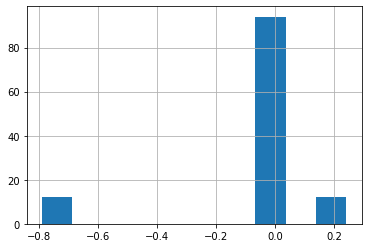

In [17]:
df["diff"].hist();

In most cases there is little or no difference (`0.0 <= d <= 0.2`) in the probabilities for the target relations.
However, some appear to be off by a substantial (`-0.8`) amount, which indicates problems in that part of  our graph data.

The following rows show where these `foaf:knows` annotations in the graph differs significantly from their truth values predicted by PSL:

In [18]:
for index, row in df.iterrows():
    p1 = row[0]
    p2 = row[1]
    diff = row["diff"]
    
    if diff < -0.2:
        print("?? acq:person_{} foaf:knows acq:person_{}".format(int(row[0]), int(row[1])))

?? acq:person_12 foaf:knows acq:person_6
?? acq:person_22 foaf:knows acq:person_21
?? acq:person_5 foaf:knows acq:person_22
?? acq:person_6 foaf:knows acq:person_12
?? acq:person_21 foaf:knows acq:person_12
?? acq:person_21 foaf:knows acq:person_22
?? acq:person_22 foaf:knows acq:person_5
?? acq:person_7 foaf:knows acq:person_5
?? acq:person_9 foaf:knows acq:person_5
?? acq:person_5 foaf:knows acq:person_9
?? acq:person_5 foaf:knows acq:person_7
?? acq:person_12 foaf:knows acq:person_21


Speaking of [*human-in-the-loop*](https://derwen.ai/d/human-in-the-loop) practices for AI, using PSL along with a KG seems like a great way to leverage machine learning, so that the people can focus on parts of the graph that have the most uncertainty.
And, therefore, probably provide the best ROI for investing time+cost into curation.

---

## Exercises

**Exercise 1:**

Build a PSL model that tests the "noodle vs. pancake" rules used in an earlier example with our recipe KG.
Which recipes should be annotated differently?

**Exercise 2:**

Try representing one of the other [PSL examples](https://github.com/linqs/psl-examples/) using RDF and `kglab`.